# Fourier Methods for Option Pricing

In [1]:
# Importing useful libraries
import numpy as np
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

### To Initialize the relevant parameters

In [2]:
#Share specific information
r=0.1
S0 = 120
sigma = 0.25

In [3]:
#Call option specific information
K=100
T=2
k_log=np.log(K)

# To Calculate the analytical price for the put option using the closed-form solution

### Analytical method using put option pricing formula

In [4]:
#Code for analytical price of European put option
d_1_stock=(np.log(S0/K)+(r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock=d_1_stock-sigma*np.sqrt(T)
analytic_putprice=-S0*norm.cdf(-d_1_stock)+K*np.exp(-r*(T))*norm.cdf(-d_2_stock)
print(analytic_putprice,'is the analytical put price using put option formula')

2.4693867508857075 is the analytical put price using put option formula


### Or We can use definition

In [5]:
def analytical_price(r, sigma, S0, K, T, t=0):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    phi = stats.norm.cdf
    return -S0*phi(-d1) + K*np.exp(-r*(T-t))*phi(-d2)

analytic_price = analytical_price(r, sigma, S0, K, T)
print(format(analytic_price),'is the analytical put price using put option formula')

2.4693867508857075 is the analytical put price using put option formula


### Analytical method using put call parity

In [6]:
#Code for analytical solution for vanilla European call option
d_1_stock=(np.log(S0/K)+(r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock=d_1_stock-sigma*np.sqrt(T)
analytic_callprice=S0*norm.cdf(d_1_stock)-K*np.exp(-r*(T))*norm.cdf(d_2_stock)
analytic_put_price=analytic_callprice-S0+K*np.exp(-r*(T))
print(analytic_callprice,'is the analytical call price')
print(analytic_put_price,'is the analytical put price using the put call parity')

40.596311443087515 is the analytical call price
2.469386750885704 is the analytical put price using the put call parity


# Fourier Transfor Method

In [7]:
# Normal random variable function

def pf(t, mu=0, s=1):
    return np.exp(1j*t*mu - (t**2)*(s**2) / 2)

def c_M1(t):
    return pf(t, mu=np.log(S0) + (r - sigma**2/2)*T, s=sigma*np.sqrt(T))
def c_M2(t):
    return pf(t, mu=np.log(S0) + (r + sigma**2/2)*T, s=sigma*np.sqrt(T))

In [8]:
# choosing upper limit of the integral and the number of partitions to sum over

t_max = 40
N = 200

def integr(f, l, r, N=200):
    delta_t = (r - l) / N
    from_1_to_N = np.linspace(1,N,N)
    t_n = (from_1_to_N - 1/2)*delta_t
    return np.sum(f(t_n)*delta_t)

def I(f):
    return lambda x: (np.exp(-1j*x*np.log(K))*f(x)).imag/x

first_integral = integr(I(c_M2), 0, t_max, N=N) 
second_integral = integr(I(c_M1), 0, t_max, N=N) 

### **printing Fourier put price**

In [9]:
fourier_put_price = -S0*(1/2 - first_integral/np.pi) + np.exp(-r*T)*K*(1/2 - second_integral/np.pi)
print(fourier_put_price,"is the fourier put price")

2.4693867508857217 is the fourier put price


# COS Method

In [10]:
# defining two useful functions upslon an psi
def upsilon_n(c, d, n, b1, b2):
    npi = n*np.pi/(b2-b1)
    npi_c = npi * (c - b1)
    npi_d = npi * (d - b1)
    numerator = np.cos(npi_d)*np.exp(d) - np.cos(npi_c)*np.exp(c) + npi * (np.sin(npi_d) * np.exp(d) - np.sin(npi_c) * np.exp(c))
    return numerator / (1+ npi**2)
def psi_n(c, d, n, b1, b2):
    if n==0:
        return d-c
    else:
        return (b2 - b1)/(n*np.pi) * (np.sin(n*np.pi*(d - b1)/(b2 - b1)) - np.sin(n*np.pi*(c - b1)/(b2 - b1)))

In [11]:
# Useful integral

def v_n(n, K, b1, b2):
    return 2/(b2 - b1) * K * (- upsilon_n(b1, 0, n, b1, b2) + psi_n(b1, 0, n, b1, b2))

def fourier_cos_put_price(r, sigma, S0, K, T, N, b1, b2):
    mu = np.log(S0/K) + (r - sigma**2/2)*T
    s = sigma*np.sqrt(T)
    npi = lambda n: n*np.pi/(b2 - b1)
    v = lambda n: v_n(n, K, b1, b2)
    first_term = v(0)*pf(0, mu=mu, s=s)/2
    second_term = np.sum([(pf(npi(n), mu=mu, s=s) * np.exp(-1j*b1*npi(n))).real * v(n) for n in range(1, N)])
    return np.exp(-r*T)*(first_term + second_term).real

In [12]:
# define the cumulants used for calculating b1 and b2
c1 = r
c2 = sigma**2 * T
c4 = 0
L = 10
b1 = c1 - L*np.sqrt(c2 + np.sqrt(c4))
b2 = c1 + L*np.sqrt(c2 + np.sqrt(c4))

In [13]:
def logchar_func(u, S0, r, sigma, K, T):
    return np.exp(1j*u*(np.log(S0/K) + (r-sigma**2/2)*T) - (sigma**2)*T*(u**2)/2)

def put_price(N, S0, sigma, r, K, T, b2, b1):
    price = v_n(0, K, b1, b2) * logchar_func(0, S0, r, sigma, K, T)/2
    for n in range(1, N):
        price += logchar_func(n*np.pi/(b2-b1), S0, r, sigma, K, T) * np.exp(-1j*n*np.pi*b1/(b2-b1)) * v_n(n, K, b1, b2)
    return price.real * np.exp(-r*T)

In [14]:
fourier_cos_prices = [fourier_cos_put_price(r, sigma, S0, K, T, n, b1, b2) for n in range (1, 51)]
print(format(fourier_cos_prices[-1]),"is the Fourier COS price for put option")

2.469386750885702 is the Fourier COS price for put option


# Plotting Results

[]

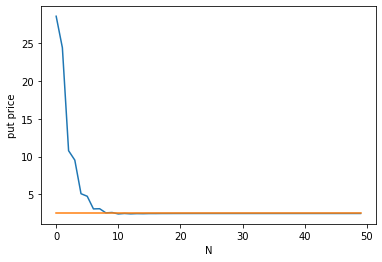

In [15]:
plt.plot(fourier_cos_prices)
plt.plot([analytic_put_price] * 50)
plt.xlabel('N')
plt.ylabel('put price')
plt.plot()

Text(0, 0.5, 'Log absolute error')

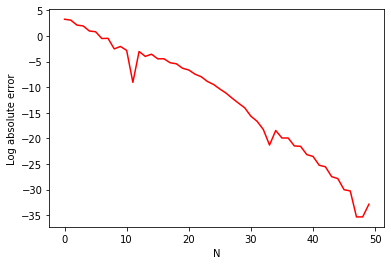

In [16]:
# Plotting the log absolute error
plt.plot(np.log(np.absolute(fourier_cos_prices-analytic_putprice)),'r')
plt.xlabel("N")
plt.ylabel("Log absolute error")

# Fast Fourier Transform

In [17]:
def FFT_put_price (r, sigma, S0, K, T, N=2**10, delta=0.25, alpha=-2):
    def c_func(v):
        val1 = np.exp(-r*T) * pf(v-(alpha+1)*1j, mu=np.log(S0)+(r-sigma**2/2)*T, s=sigma*np.sqrt(T))
        val2 = alpha**2 + alpha - v**2 + 1j*(2*alpha + 1)*v
        return val1/val2
    
    n = np.array(range(N))
    delta_k = 2*np.pi/(N*delta)
    b = delta_k * (N-1)/2
    
    log_strike = np.linspace(-b, b, N)
    
    x = np.exp(1j*b*n*delta)*c_func(n*delta)*delta
    x[0] = x[0]*0.5
    x[-1] = x[-1]*0.5
    
    x_hat = np.fft.fft(x).real
    fft_put = np.exp(-alpha*log_strike)*x_hat/np.pi
    
    return log_strike, fft_put

In [18]:
log_strike, fft_price = FFT_put_price(r, sigma, S0, K, T)
analytic_prices = np.array([analytical_price(r, sigma, S0, np.exp(log_strike), T)]).reshape(log_strike.shape) 

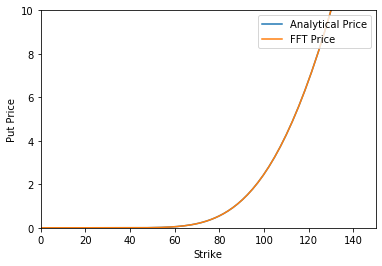

In [19]:
plt.plot(np.exp(log_strike), analytic_prices, label="Analytical Price")
plt.plot(np.exp(log_strike), fft_price, label="FFT Price") 
plt.axis([0,150,0,10]) # rescale
plt.xlabel("Strike")
plt.ylabel("Put Price")
plt.legend(loc="upper right")
plt.show() 

**Within this above graph there are two combined graph, the blue graph fr analytical price and yellow grapg for FFT price**

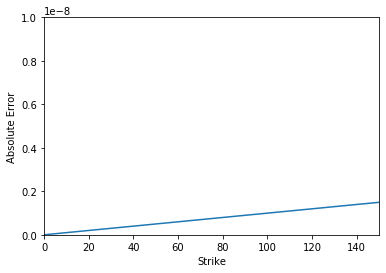

In [20]:
plt.plot(np.exp(log_strike), np.absolute(fft_price - analytic_prices))
plt.axis([0, 150, 0, 0.00000001])
plt.xlabel("Strike")
plt.ylabel("Absolute Error")
plt.show()

## For N=$2^{10}$ we have

In [21]:
K_near = np.abs(log_strike - np.log(K)).argmin()
print(f"Nearest strike price is: {np.exp(log_strike[K_near]):.4f}")
print("the FFT price at this trike is: {0:.4f}".format(fft_price[K_near]))
print("the Analytical price at this trike is: {0:.4f}".format(analytic_prices[K_near]))

Nearest strike price is: 99.6777
the FFT price at this trike is: 2.4215
the Analytical price at this trike is: 2.4215


With these above nearest value we can see that we are not enough closer to the strike K=100